# Answering Business Questions Using SQL

## Introduction
In this project, we'll be answering some general business questions using the modified version of the [Chinook database](https://github.com/lerocha/chinook-database). This database represents media related data that was created using real data from an iTunes Library. 

Here are the following questions we are interested in answering:
1. Given 4 new albums, which albums should Chinook add to their store? 
2. Who had the top sales performance amongst the sales agents?
3. Which countries had the most sales? 
4. Chinook is looking to change their purchasing strategy, so are individual track sales or album sales more popular?
5. Which artist is used in the most playlists?
6. How many tracks have been purchased vs not purchased?
7. Is the range of tracks in the store reflective of their sales popularity?
8. Do protected vs. non-protected media types have an effect on popularity?

Here's a schema diagram of the database:


## Connect to Database and Overview

In [1]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

In [2]:
%%sql
SELECT name, 
       type
FROM sqlite_master
WHERE type in ("table","view");

 * sqlite:///chinook.db
Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [3]:
%%sql 
SELECT * 
FROM invoice AS i
INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
LIMIT 10;

 * sqlite:///chinook.db
Done.


invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total,invoice_line_id,invoice_id_1,track_id,unit_price,quantity
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,1,1,1158,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,2,1,1159,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,3,1,1160,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,4,1,1161,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,5,1,1162,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,6,1,1163,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,7,1,1164,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,8,1,1165,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,9,1,1166,0.99,1
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84,10,1,1167,0.99,1


We can see that there are 11 tables in this database that include information about the invoices, artists, albums, playlists, and so on. 

## 1. Which of the 4 albums should Chinook add to the store?

The Chinook record store just signed a deal with a new record label that focuses on artists in the USA. We have been tasked to select 3 of the 4 albums listed below. 

| Artist Name | Genre |
| --- | --- |
| Regal | Hip-Hop |
| Red Tone | Punk |
| Metero and the Girls | Pop |
| Slim Jim Bites | Blues |


We have the artists' names and genre of music they produce. To answer the question above, we should look at the most popular genres in the USA. To do this, we'll find the total tracks sold by each genre in the USA and the % of total tracks sold. We can retrieve this information from the `customer`, `invoice`, `invoice_line`, `track`, and `genre` tables by using multiple `LEFT JOIN` keywords.

,rank,genre_name,tracks_sold,pct_sold
0,1,Rock,561,53.38
1,2,Alternative & Punk,130,12.37
2,3,Metal,124,11.80
3,4,R&B/Soul,53,5.04
4,5,Blues,36,3.43
5,6,Alternative,35,3.33
6,7,Latin,22,2.09
7,8,Pop,22,2.09
8,9,Hip Hop/Rap,20,1.90
9,10,Jazz,14,1.33


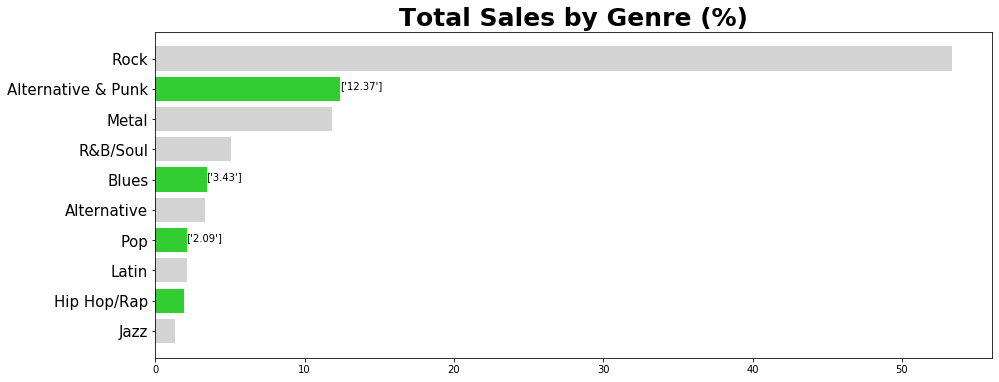

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
%matplotlib inline

album_query = """
WITH 

/* Selecting the customers that are from the USA */

usa AS (SELECT * 
        FROM customer
        WHERE country = 'USA'),

/* Joining the invoice and invoice line tables to the USA customers table */

usa_il AS (SELECT * 
           FROM usa
           LEFT JOIN invoice i ON usa.customer_id = i.customer_id
           LEFT JOIN invoice_line il ON i.invoice_id = il.invoice_id),
           
/* Joining the track and genre tables to the USA customers' invoice table */ 

usa_info AS (SELECT usa_il.*,
                    g.genre_id genre_id,
                    g.name genre_name
             FROM usa_il
             LEFT JOIN track t ON usa_il.track_id = t.track_id
             LEFT JOIN genre g ON t.genre_id = g.genre_id)  
             
/* Adding the rank for the genres, and counting the tracks sold by genre */ 

SELECT ROW_NUMBER() OVER(ORDER BY COUNT(*) DESC) rank, 
       genre_name,
       COUNT(*) tracks_sold,
       ROUND(CAST(COUNT(*) AS FLOAT) / (SUM(COUNT(genre_name)) OVER())*100,2) AS pct_sold
FROM usa_info
GROUP BY genre_name
ORDER BY tracks_sold DESC

"""

conn = sqlite3.connect("chinook.db")
album = pd.read_sql_query(album_query, conn)

## Top 10 genres
top_genres = album.head(10).sort_values(by=['pct_sold'], ascending=True)

## Getting a list of all the different genres
genre_names = list(top_genres['genre_name'].values)

## Genres of the albums we are looking to add
album_genres = ['Hip Hop/Rap', 'Pop', 'Blues', 'Alternative & Punk']

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()

ax.barh(top_genres['genre_name'],top_genres['pct_sold'], color='lightgrey')

## Coloring the album's genres green
for x in album_genres:
    ax.barh(x, top_genres[top_genres['genre_name'] == x]['pct_sold'].values, color='limegreen')
    if x != 'Hip Hop/Rap':
        ax.text(x=top_genres[top_genres['genre_name']==x]['pct_sold'].values, y=x, 
                s=top_genres[top_genres['genre_name']==x]['pct_sold'].values.astype(str)) ## adding astype(str) bypasses a future warning, not sure why

ax.set_yticklabels(labels=genre_names,fontdict={'fontsize':15})
plt.title("Total Sales by Genre (%)", fontdict={'fontsize':25,'fontweight':'bold'})

album


### Findings

| Artist Name | Genre | Genre Rank |
| --- | --- | --- |
| Regal | Hip-Hop | 9 |
| Red Tone | Punk | 2 |
| Metero and the Girls | Pop | 8 |
| Slim Jim Bites | Blues | 5 |

So given the ranked list of genres above, Hip-Hop ranks **9th**, Punk ranks **2nd**, Pop ranks **8th**, and Blues ranks **5th**. 

We can advise Chinook to add **Red Tone's, Metero and the Girls', and Slim Jim Bites' albums**. However, we can see that **Rock takes up 53%** of the tracks sold in the USA, so one recommendation is to have Chinook look into having more rock artists and albums. 

## 2. Exploring Customer Purchases Based on Employees

Whenever a customer first makes a purchase, they are assigned to a sales support representative. We were tasked to analyze employee performance based on the number of and total sales each one has. We can retrieve this information through the `employee`, `customer`, `invoice`, and `invoice_line` tables.

,employee_name,birthdate,hire_date,country,num_transactions,dollar_sales,pct_sales,avg_dollar_sale
0,Jane Peacock,1973-08-29 00:00:00,2017-04-01 00:00:00,Canada,212,1731.51,36.77,8.17
1,Margaret Park,1947-09-19 00:00:00,2017-05-03 00:00:00,Canada,214,1584.00,33.63,7.40
2,Steve Johnson,1965-03-03 00:00:00,2017-10-17 00:00:00,Canada,188,1393.92,29.60,7.41


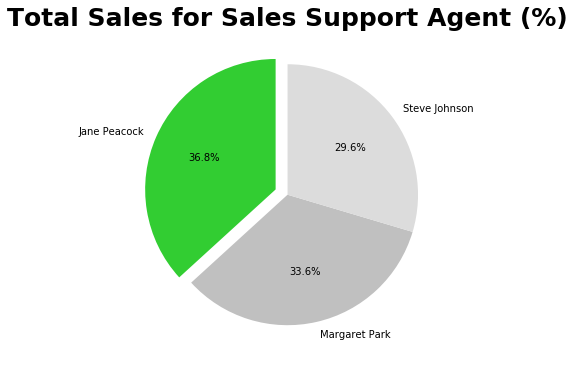

In [5]:
employee_query = """
WITH 

/* Selecting only the Sales Support Agent employees */

sales_agents AS (SELECT * 
                 FROM employee
                 WHERE title = 'Sales Support Agent'),
       
/* Joining the customer, invoice, invoice line, track, and genre tables with sales_agents */

e_info AS (SELECT * 
           FROM sales_agents s
           LEFT JOIN customer c ON s.employee_id = c.support_rep_id
           INNER JOIN invoice i ON c.customer_id = i.customer_id)
                       
/* Selecting the employee's name and their info, their total sales in $ and in quantity */
    
SELECT first_name || ' ' || last_name employee_name,
       birthdate,
       hire_date,
       country,
       COUNT(*) num_transactions,
       ROUND(SUM(total),2) dollar_sales,
       ROUND(SUM(total) / (SELECT SUM(total)
                           FROM e_info) * 100,2) pct_sales,
       ROUND((SUM(total) / COUNT(*)),2) avg_dollar_sale
FROM e_info 
GROUP BY employee_id;

"""

employee_info = pd.read_sql_query(employee_query, conn)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()
colors = ['limegreen','silver','gainsboro']

ax.pie(x=employee_info['pct_sales'], 
       labels=employee_info['employee_name'], 
       colors=colors,
       explode=(0.1,0,0), 
       autopct="%1.1f%%", startangle=90)

plt.title("Total Sales for Sales Support Agent (%)", 
          fontdict={'fontsize':25,'fontweight':'bold'})


employee_info



### Findings

We can see that all sales agents were from Canada and hired in 2017. **Jane Peacock** had the most number of transactions and total sales. Not surprisingly, we can see that the earlier the hire date, the more transactions and total sales the sales agent had. This can be due to the agent having more experience and thus finding it easier to close sales. 

**Jane** had the most sales as she held **38% of total sales**, while **Margaret and Steve** held **33% and 28% respectively**. Some factors that may contribute to this is the earlier hire date and also the age of each agent. Jane was the youngest of the 3, while Margaret was the oldest.

Something interesting to note is that there might be a correlation between average dollar sale and hire date. (Earlier the start date = Higher average dollar sale)

## 3. Analyzing Customers From Different Countries

Next, we were tasked to analyze the sales data for customers from each country. Specifically, we can look at the total number of customers, total value of sales, average value of sales per customer, and average order value. We can retrieve these values from the `customers` and `invoice` tables. 

**Important note**: 
- We are going to use the `country` value in the `customers` table rather than the `invoice` table because we are analyzing ALL customers rather than the customers who made a purchase.
- A country that has exactly 1 customer is going to be classified as `Other`.

,countries,customers,total_sales,avg_sales_per_cust,avg_order_value
0,USA,13,1040.49,10,7.94
1,Canada,8,535.59,9,7.05
2,Brazil,5,427.68,12,7.01
3,France,5,389.07,10,7.78
4,Germany,4,334.62,10,8.16
5,Czech Republic,2,273.24,15,9.11
6,United Kingdom,3,245.52,9,8.77
7,Portugal,2,185.13,14,6.38
8,India,2,183.15,10,8.72
9,Other,15,1094.94,9,7.45


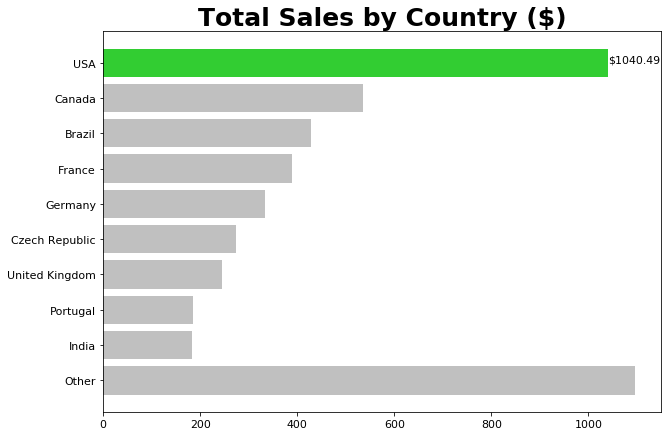

In [6]:
customer_country_query = """
WITH 

/* Counting the number of unique customers by country */

nc AS (SELECT country,
              COUNT(c.customer_id) num_cust
       FROM customer c
       GROUP BY country),
       
       
/* Joining the customer and invoice tables */

ci AS (SELECT * 
       FROM customer c
       INNER JOIN invoice i ON c.customer_id = i.customer_id),
       
       
/* Computing the sales data by country */

ci_2 AS (SELECT CASE
                    WHEN nc.num_cust = 1 THEN 'Other'
                    ELSE nc.country
                    END countries,
                COUNT(DISTINCT(customer_id)) customers,
                ROUND(SUM(ci.total),2) total_sales,
                COUNT(ci.invoice_id) / COUNT(DISTINCT(customer_id)) avg_sales_per_cust,
                ROUND(AVG(ci.total),2) avg_order_value
         FROM nc
         INNER JOIN ci ON nc.country = ci.country
         GROUP BY countries
         ORDER BY total_sales DESC)
         
            
/* Listing the 'Other' countries last */

SELECT countries,
       customers,
       total_sales,
       avg_sales_per_cust,
       avg_order_value
FROM (SELECT ci_2.*,
             CASE
                 WHEN ci_2.countries = 'Other' THEN 1
                 ELSE 0
             END sort
    FROM ci_2)
ORDER BY sort ASC;

"""

customers_by_countries = pd.read_sql_query(customer_country_query, conn)

## Flipped the table to make USA appear first in the graph
cc = customers_by_countries[::-1]

fig, ax = plt.subplots(figsize=(10,7))

ax.barh(cc['countries'], 
        cc['total_sales'], 
        color=['silver','silver','silver','silver','silver',
              'silver','silver','silver','silver','limegreen'])

ax.set_title("Total Sales by Country ($)", fontdict={'fontsize':25, 'fontweight':'bold'})

ax.tick_params(labelsize=11)

ax.text(x=cc[cc['countries']=='USA']['total_sales'],
        y='USA',
        s='$1040.49',
        fontdict={'fontsize':11})

customers_by_countries
    

### Findings

Based on our findings above, **USA** had the most customers and total sales. We can see a **positive correlation** between number of `customers` and `total sales`. Something interesting to point out is that Czech Republic's customers had the highest average for sales per customer and order value; however there were only 2 unique customers. Portugal had the 2nd highest average sales per customer, but the lowest average order value.

From this, we can recommend Chinook add the most popular genres in each country to diversify their target market or to find ways to continuously increase their sales in the USA. 

## 4. Do people buy whole albums or single tracks more often?

The Chinook store has 2 purchasing methods for the customers. They can either buy the whole album or purchase each individual track. Previously, Chinook did not allow customers to combine these types of purchases together. They are considering changing their purchasing strategy to save money by buying the most popular tracks from the albums rather than the whole thing.  

Some 'edge cases' we have to consider are that albums with 1 or 2 tracks are likely to be sold as individual tracks and customers may decide to purchase all tracks separately from an album and add a few individual tracks. We can ignore these 2 cases because we are focused on maximizing revenue and the company claims the 2nd case does not happen often. 

We can answer the question above by finding the percentages of purchases (individual vs. album) and number of purchases for each. To figure out whether not the customer bought a whole album or individual tracks, we must compare the total number of tracks in the album and see if this number equals the number of tracks in the invoice based on the `album_id`. We can retrieve this information from the `track` and `invoice_line` tables.

,purchase_type,invoice_count,pct
0,Album,111,18.08
1,Individual Tracks,503,81.92


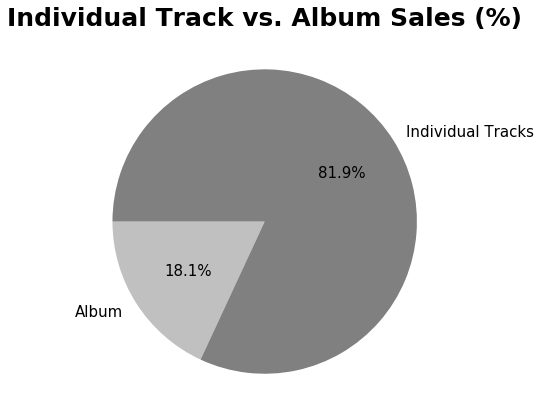

In [7]:
purchase_type_query = """
WITH 

/* Getting the amount of tracks in each album */

a_ct AS (SELECT t.album_id, 
                COUNT(t.track_id) tracks_per_album 
         FROM track t
         GROUP BY album_id),
         

/* Getting the amount of tracks based on each invoice and album */ 

t_ct AS (SELECT il.invoice_id,
                t.album_id,
                COUNT(il.track_id) track_count
         FROM track t
         INNER JOIN invoice_line il ON t.track_id = il.track_id
         GROUP BY il.invoice_id, t.album_id),
         

/* Comparing the invoice track count per album to the total track count per album */

ind_vs_alb AS (SELECT *,
                      CASE
                          WHEN t_ct.track_count != a_ct.tracks_per_album THEN 'Individual Tracks'
                          WHEN t_ct.track_count = 1 THEN 'Individual Tracks'
                          ELSE 'Album'
                      END purchase_type
               FROM t_ct
               INNER JOIN a_ct ON t_ct.album_id = a_ct.album_id)
               

/* Counting the occurrences for each purchase type */

SELECT purchase_type,
       COUNT(DISTINCT(invoice_id)) invoice_count,
       ROUND(CAST(COUNT(DISTINCT(invoice_id)) AS FLOAT) / (SELECT COUNT(DISTINCT(invoice_id)) 
                                                           FROM ind_vs_alb),4) * 100 pct
FROM ind_vs_alb
GROUP BY purchase_type;

"""

purchase_type = pd.read_sql_query(purchase_type_query, conn)

fig, ax = plt.subplots(1,1, figsize=(10,7))

ax.pie(x=purchase_type['pct'], 
       labels=purchase_type['purchase_type'], 
       colors=['silver','gray'], 
       autopct='%1.1f%%', 
       startangle=180, 
       textprops={'fontsize':15})

plt.title("Individual Track vs. Album Sales (%)", fontdict={'fontsize':25,'fontweight':'bold'})

purchase_type

### Findings

Based on our findings above, customers buy **individual tracks** more frequently than **albums**, with each purchase type holding **81.92%** and **18.08%** of sales respectively. 

From this, we recommend Chinook to not continue buying full albums from record companies, but rather buy the most popular tracks from each album. We can look at the top selling albums/tracks from each genre and advise Chinook to buy more of these specific tracks. 

## 5. Which artist is used in the most playlists?

Chinook is trying to figure out the most common artist amongst the playlists. So, we would want to see how many times an artist occurs in each playlist. To do this, the information we need is in the `artist` and `playlist_track` tables.

In [8]:
top_artists_query = """

WITH 

/* Selecting all the artists and counting the number of playlists they are in */

q1 AS (SELECT art.name artist_name,
              COUNT(DISTINCT(pl.playlist_id)) num_playlists
       FROM artist art
       INNER JOIN album al ON art.artist_id=al.artist_id
       INNER JOIN track t ON al.album_id=t.album_id
       INNER JOIN playlist_track pl ON t.track_id=pl.track_id
       GROUP BY artist_name
       ORDER BY num_playlists DESC)
       

/* Top 10 */

SELECT * FROM q1
LIMIT 10;

"""

top_artists = pd.read_sql_query(top_artists_query, conn)
top_artists

,artist_name,num_playlists
0,Eugene Ormandy,7
1,The King's Singers,6
2,English Concert & Trevor Pinnock,6
3,Berliner Philharmoniker & Herbert Von Karajan,6
4,Academy of St. Martin in the Fields & Sir Nevi...,6
5,Yo-Yo Ma,5
6,Wilhelm Kempff,5
7,Ton Koopman,5
8,"Sir Georg Solti, Sumi Jo & Wiener Philharmoniker",5
9,Sir Georg Solti & Wiener Philharmoniker,5


### Findings

Based on our findings, we see that **Eugene Ormandy** was the most common artist amongst the playlists, being in **7** different playlists. There were 4 other artists that were in 6 playlists and many other artists that were in 5 playlists or fewer. 

From this, we can look into how well Eugene Ormandy (and the other artists) is selling and decide whether or not to sell more of his songs.

## 6. How many tracks have been purchased vs not purchased?

The Chinook store is trying to see what songs are purchased and not purchased. First, they want to see how much of their inventory is actually being sold. To do this, we must find the number of tracks sold and not sold and the percentage of each. We will compare all the tracks in the `track` table with the `invoice_line` table and if it's not in the `invoice_line` table then it was not purchased. 

,purchased,num_tracks,pct
0,Not Purchased,1697,48.4
1,Purchased,1806,51.6


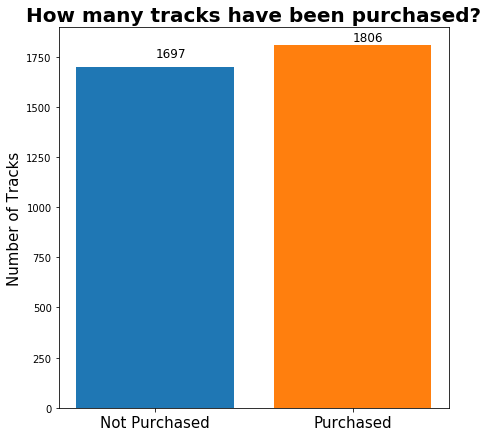

In [9]:
purchase_query = """

/* Comparing the tracks from the track table and invoice_line table */

SELECT CASE 
           WHEN EXISTS (SELECT *
                        FROM invoice_line il
                        WHERE il.track_id = t.track_id)
           THEN "Purchased"
           ELSE "Not Purchased"
       END AS purchased,
       COUNT(*) num_tracks,
       ROUND(CAST(COUNT(*) AS FLOAT) / (SELECT COUNT(*) FROM track),3) * 100 pct 
FROM track t
GROUP BY purchased

"""

purchased = pd.read_sql_query(purchase_query, conn)

fig, ax = plt.subplots(figsize=(7,7))
color = ['tab:blue', 'tab:orange']

ax.bar(purchased['purchased'], purchased['num_tracks'], color=color)

## Labeling the values on the bars
ax.text(x='Not Purchased', 
        y=1750, 
        s='1697', 
        fontdict={'fontsize':12})
ax.text(x='Purchased', 
        y=1830, 
        s='1806',
        fontdict={'fontsize':12})

ax.set_ylabel("Number of Tracks", 
              fontdict={'fontsize':15})

plt.xticks(fontsize=15)

plt.title("How many tracks have been purchased?", 
          fontdict={'fontsize':20, 'fontweight':'bold'})

purchased


### Findings
Based on our findings, we can see that **1806 (51.56%)** out of 3503 total tracks were **purchased**.  So, this means **48.44%** of the tracks in the store were **not purchased**. If Chinook is having a problem with their sales, they may want to look into adding more popular artists and removing the artists that aren't selling well or at all. 

## 7. Is the range of tracks in the store reflective of their sales popularity?
The Chinook store is looking to diversify their store's selection. They want to find out if having more tracks correlates with sales popularity. To do this, we will find the total number of tracks in each genre and the total sales for each. We can retrieve this information from the `track`, `genre`, `invoice`, and `invoice_line` tables.

,total_sales,total_tracks
total_sales,1.000000,0.929652
total_tracks,0.929652,1.000000


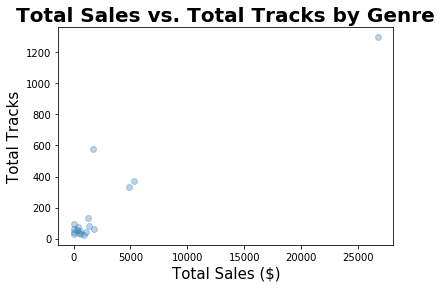

In [10]:
t_variety_vs_sales_query = """

WITH 

/* Total number of tracks for each genre */

total_tracks AS (SELECT g.name genre_name,
                        COUNT(t.track_id) total_tracks
                 FROM track t
                 INNER JOIN genre g ON t.genre_id=g.genre_id
                 GROUP BY genre_name),
                 
                 
/* Total sales for each genre */

total_sales AS (SELECT g.name genre_name,
                       ROUND(SUM(i.total),2) total_sales
                FROM track t
                INNER JOIN genre g ON t.genre_id=g.genre_id
                INNER JOIN invoice_line il ON t.track_id=il.track_id
                INNER JOIN invoice i ON il.invoice_id=i.invoice_id
                GROUP BY genre_name)

SELECT ts.*,
       tt.total_tracks
FROM total_sales ts
INNER JOIN total_tracks tt ON ts.genre_name=tt.genre_name

"""

data = pd.read_sql_query(t_variety_vs_sales_query, conn)

plt.scatter(data['total_sales'], data['total_tracks'], alpha=0.3)
plt.title("Total Sales vs. Total Tracks by Genre", fontdict={'fontsize':20,'fontweight':'bold'})
plt.xlabel("Total Sales ($)", fontsize=15)
plt.ylabel("Total Tracks", fontsize=15)

## Correlation table
data.corr()

### Findings

Based on our findings above, we can see that there is a strong positive correlation with total tracks and total sales for each genre, with a correlation of **.929**. 

From this, we can recommend Chinook to find the most popular tracks in each genre and diversify their store selection.

## 8. Do protected vs. non-protected media types have an effect on popularity?

The Chinook store is curious to see which media type is the most popular (protected vs. non-protected). To do this, we will assign each track to either be protected or non-protected, depeneding on their `media_type_id`. Then, we will calculate the percentage of total sales and number of sales for each. We can retrieve this information from the `media_type`, `invoice`, and `track` tables.

,media_type,num_invoice,total_sales,pct
0,Non-Protected,4315,43362.00,90.7
1,Protected,442,4141.17,9.3


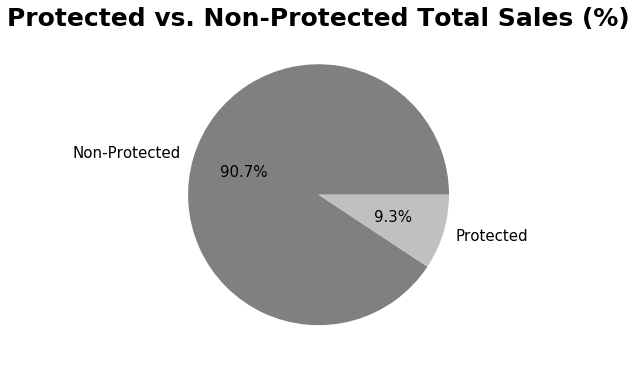

In [11]:
protected_query = """

WITH

/* Selecting the "protected" media types */

q1 AS (SELECT * 
       FROM media_type
       WHERE name LIKE "%Protected%"),


/* Gathering the data to calculate total and number of sales AND classifying the invoices as protected/non-protected */

q2 AS (SELECT i.invoice_id,
              t.media_type_id,
              i.total,
              CASE
                  WHEN t.media_type_id = q1.media_type_id
                  THEN "Protected"
                  ELSE "Non-Protected"
              END AS media_type
       FROM invoice i
       INNER JOIN invoice_line il ON i.invoice_id = il.invoice_id
       INNER JOIN track t ON il.track_id = t.track_id
       LEFT JOIN q1 ON t.media_type_id = q1.media_type_id)
       

/* Calculating the totals, counts, and percentages */

SELECT media_type,
       COUNT(invoice_id) num_invoice,
       ROUND(SUM(total), 4) total_sales,
       ROUND(CAST(COUNT(invoice_id) AS FLOAT) / (SELECT COUNT(invoice_id)
                                                 FROM q2),3) * 100 pct
FROM q2
GROUP BY media_type

"""

protected = pd.read_sql_query(protected_query, conn)

fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot()
colors = ['grey','silver']

ax.pie(x=protected['pct'], 
       labels=protected['media_type'], 
       colors=colors, 
       autopct="%1.1f%%", 
       textprops={'fontsize':15})

plt.title("Protected vs. Non-Protected Total Sales (%)", 
          fontdict={'fontsize':25,'fontweight':'bold'})

protected


### Findings

Based on our findings above, we can see that **non-protected** tracks took up **90.7%** of total sales. This does not imply causation, but simply a positive correlation. We can recommend Chinook to buy less of protected tracks as it does not yield that many sales.

# Conclusion

In this project, we used a modified version of the Chinook database to answer general business questions. The questions we addressed are as follows:
1. Given 4 new albums, which albums should Chinook add to their store? 
2. Who had the top sales performance amongst the sales agents?
3. Which countries had the most sales? 
4. Chinook is looking to change their purchasing strategy, so are individual track sales or album sales more popular?
5. Which artist is used in the most playlists?
6. How many tracks have been purchased vs not purchased?
7. Is the range of tracks in the store reflective of their sales popularity?
8. Do protected vs. non-protected media types have an effect on popularity?

### Main Results
1. Given the 4 albums, Chinook should add **Red Tone's (Punk)**, **Metero and the Girls' (Blues)**, and **Slim Jim Bites' albums (Pop)**. Based on genres, **punk** ranked **2nd with 12.37% of sales**, **blues** ranked **5th with 3.43%**, **pop** ranked **8th with 2.09%**. 
2. Out of the 3 sales support agents, **Jane Peacock** had the top sales performance with **38% of total sales, 1749 transactions, \\$18,246.69 in total sales**, and an **average sale of \\$10.43.**
3. **USA** had the most sales with **13 customers** and **\\$1040.49 in total sales, 10 sales per customer**, and **an average order value of \\$7.94**.
4. With the 2 types of purchases, people bought **individual tracks** more often than whole albums. Individual track sales held **81.92% of total sales** with **503 unique invoices**.
5. **Eugene Ormandy** was the most common artist amongst the playlists, being in **7** different playlists.
6. **1806 (51.56%)** out of 3503 total tracks were **purchased**.
7. There is a **strong positive correlation** with range of tracks and total sales for each genre, with a correlation of **.929.**
8. **Non-protected** tracks took up **90.7%** of total sales. This does not imply causation, but simply a positive correlation.

### Recommendations
1. Chinook should look into adding more rock albums as the genre held 53.38% of total sales coming in as the most popular genre. The second most popular genre was alternative and punk with only 12.37% of sales.
2. Jane Peacock had the earliest start date and was the youngest of the sales support agents. So, Chinook may want to look into what young employees do differently than older employees to increase sales. 
3. Dependent on Chinook's sales strategy, they can either find more music that appeals to USA and increase average sales per customer by product bundling OR find other music that appeals to other countries to diversify their target market.
4. Knowing that individual track sales happen more frequently, Chinook should look into the tracks that are the most popular in each album and buy those specific tracks. 
5. Look into how well Eugene Ormandy's songs sell and decide whether or not to sell more of his songs.
6. With about half of the tracks not being sold, Chinook should add more popular artists and remove the artists that are not selling well at all.
7. Chinook may want to consider adding more popular tracks in each genre to diversify their store selection.
8. With 90.7% of sales consisting of non-protected tracks, we can recommend to buy less of protected tracks as it does not yield more sales.